In [1]:
!nvidia-smi

Fri Mar 15 14:33:33 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   37C    P0    71W / 250W |      0MiB / 12195MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from os import path as p
import os
from plot_history import plot_history

In [1]:
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten
from keras.models import Model
from keras.losses import categorical_crossentropy, mse
from keras.optimizers import Adadelta, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

Using TensorFlow backend.


In [4]:
data_dir = '/storage/yw18581/data/'
data_folder = p.join(data_dir, 'train_validation_test')

In [5]:
X_train = np.load(p.join(data_folder, 'Xy_train_dist.npz'))["y"]
y_train = np.load(p.join(data_folder, 'Xy_train_dist.npz'))["dist"]

In [6]:
X_val = np.load(p.join(data_folder,'Xy_val_dist.npz'))["y"]
y_val = np.load(p.join(data_folder, 'Xy_val_dist.npz'))["dist"]

In [7]:
X_test = np.load(p.join(data_folder, 'Xy_test_dist.npz'))["y"]
y_test = np.load(p.join(data_folder, 'Xy_test_dist.npz'))["dist"]

In [8]:
X_pred = np.load(p.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['y']
y_pred = np.load(p.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['dist']

In [9]:
def cut_X(arr, reshape = None):
    x_cut = arr[:,960:1300,600:]
    if reshape:
        if len(x_cut.shape)>3:
            x_cut = x_cut[...,0]
            x_cut_out = x_cut.reshape(x_cut.shape[0],x_cut.shape[1]*x_cut.shape[2])
    else:
        x_cut_out = x_cut
    return x_cut_out

In [10]:
def ohe(values):
    values_reshaped = values.reshape(-1, 1)
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    onehot_encoded = onehot_encoder.fit_transform(values_reshaped)
    return onehot_encoded

In [11]:
X_train.shape

(768, 1400, 1400, 1)

In [12]:
X_train_cut = cut_X(X_train)

In [13]:
X_train_cut.shape

(768, 340, 800, 1)

In [14]:
X_val_cut = cut_X(X_val)

In [15]:
X_test_cut = cut_X(X_test)

In [16]:
X_pred_cut = cut_X(X_pred)

In [17]:
y_train_ohe = ohe(y_train)
y_val_ohe = ohe(y_val)
y_test_ohe = ohe(y_test)

In [18]:
N_EPOCHS = 100
BATCH_SIZE = 16

CHECKPOINT_FOLDER_PATH = p.join(data_dir, 'trained_models')
TASK_NAME = 'Leaf_position_classifier_CNN'
TASK_FOLDER_PATH = p.join(CHECKPOINT_FOLDER_PATH, TASK_NAME)

if not p.exists(TASK_FOLDER_PATH):
    os.makedirs(TASK_FOLDER_PATH)

In [19]:
K.clear_session()



In [20]:

def create_model(input_shape):
    input_layer = Input(shape=input_shape,name='input')
    x = Conv2D(32,kernel_size=3, activation='relu')(input_layer)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation ='sigmoid')(x)
    prediction = Dense(4, activation='sigmoid')(x)
    model = Model(inputs = input_layer, outputs = prediction)
    return model

model = create_model(input_shape=(X_train_cut.shape[1:]))
OPTIMIZER = 'Adam'
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])

callbacks = [#EarlyStopping(monitor='val_acc',patience = 8, verbose = True), 
             ModelCheckpoint(os.path.join(TASK_FOLDER_PATH,"leaf_classifier_CNN_{}epochs_{}batch_{}.hdf5".format(N_EPOCHS,BATCH_SIZE, str(OPTIMIZER))), 
                             monitor='val_acc')]


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 340, 800, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 338, 798, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 169, 399, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2157792)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               276197504 
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 276,198,340
Trainable params: 276,198,340
Non-trainable params: 0
______________________________________________________________

In [21]:
history = model.fit(X_train_cut, y_train_ohe, validation_data=(X_val_cut, y_val_ohe),
                    epochs=N_EPOCHS, verbose=True, batch_size=BATCH_SIZE, shuffle=True, 
                    callbacks = callbacks)

Train on 768 samples, validate on 192 samples
Epoch 1/100
768/768 [==============================] - 26s 34ms/step - loss: 1.2222 - acc: 0.4805 - val_loss: 1.0335 - val_acc: 0.5104
Epoch 2/100
768/768 [==============================] - 8s 10ms/step - loss: 0.8520 - acc: 0.7148 - val_loss: 0.6754 - val_acc: 0.7969
Epoch 3/100
768/768 [==============================] - 7s 10ms/step - loss: 0.6076 - acc: 0.7878 - val_loss: 0.5107 - val_acc: 0.7969
Epoch 4/100
768/768 [==============================] - 7s 10ms/step - loss: 0.4993 - acc: 0.7812 - val_loss: 0.4373 - val_acc: 0.7969
Epoch 5/100
768/768 [==============================] - 7s 10ms/step - loss: 0.4413 - acc: 0.8971 - val_loss: 0.3920 - val_acc: 1.0000
Epoch 6/100
768/768 [==============================] - 8s 10ms/step - loss: 0.4005 - acc: 0.9674 - val_loss: 0.3533 - val_acc: 1.0000
Epoch 7/100
768/768 [==============================] - 7s 10ms/step - loss: 0.3693 - acc: 1.0000 - val_loss: 0.3286 - val_acc: 1.0000
Epoch 8/100
768

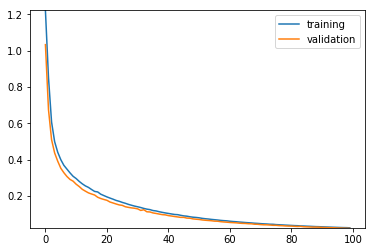

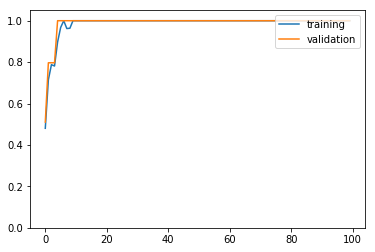

In [38]:
plot_history(history, ymin_acc=0, ymax_acc=1.05)

In [39]:
preds = model.predict(X_test_cut)

In [40]:
preds_classes = np.argmax(preds, axis=-1)

In [41]:
preds_classes

array([3, 2, 0, 1, 0, 3, 1, 3, 1, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 2,
       2, 1, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 2, 3, 0, 3, 1,
       3, 1, 1, 0, 0, 0, 2, 3, 1, 0, 3, 1, 3, 3, 3, 1, 1, 0, 0, 0, 0, 3,
       0, 1, 1, 1, 1, 0, 3, 0, 0, 1, 0, 0, 3, 2, 3, 0, 2, 0, 1, 3, 3, 0,
       3, 2, 1, 1, 0, 1, 3, 2, 1, 3, 0, 0, 1, 0, 2, 0, 2, 2, 3, 3, 3, 3,
       1, 2, 0, 3, 2, 3, 0, 0, 2, 0, 1, 3, 3, 3, 1, 3, 1, 0, 2, 2, 0, 3,
       1, 0, 3, 2, 2, 1, 1, 3, 3, 2, 1, 2, 2, 1, 2, 2, 1, 1, 3, 1, 2, 0,
       3, 1, 1, 0, 3, 1, 3, 3, 3, 0, 0, 2, 0, 2, 2, 0, 2, 3, 1, 0, 0, 1,
       0, 3, 0, 2, 2, 2, 0, 3, 0, 3, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 0, 3,
       3, 0, 2, 3, 2, 3, 2, 0, 2, 2, 2, 3, 3, 2, 1, 2, 3, 0, 2, 0, 2, 1,
       3, 3, 3, 3, 0, 1, 2, 0, 0, 2, 1, 0, 3, 2, 3, 1, 2, 1, 3, 2])

In [42]:
y_test

array([25, 10,  2,  4,  2, 25,  4, 25,  4, 10, 10,  2,  2, 10,  2,  2,  4,
       10, 10,  4,  4, 10, 10,  4,  2,  2, 10,  4,  4,  4,  4, 10, 10, 10,
        4,  4,  4,  2,  4, 10, 25,  2, 25,  4, 25,  4,  4,  2,  2,  2, 10,
       25,  4,  2, 25,  4, 25, 25, 25,  4,  4,  2,  2,  2,  2, 25,  2,  4,
        4,  4,  4,  2, 25,  2,  2,  4,  2,  2, 25, 10, 25,  2, 10,  2,  4,
       25, 25,  2, 25, 10,  4,  4,  2,  4, 25, 10,  4, 25,  2,  2,  4,  2,
       10,  2, 10, 10, 25, 25, 25, 25,  4, 10,  2, 25, 10, 25,  2,  2, 10,
        2,  4, 25, 25, 25,  4, 25,  4,  2, 10, 10,  2, 25,  4,  2, 25, 10,
       10,  4,  4, 25, 25, 10,  4, 10, 10,  4, 10, 10,  4,  4, 25,  4, 10,
        2, 25,  4,  4,  2, 25,  4, 25, 25, 25,  2,  2, 10,  2, 10, 10,  2,
       10, 25,  4,  2,  2,  4,  2, 25,  2, 10, 10, 10,  2, 25,  2, 25,  4,
       10,  4,  4, 10, 10,  2, 10,  4,  2,  2, 25, 25,  2, 10, 25, 10, 25,
       10,  2, 10, 10, 10, 25, 25, 10,  4, 10, 25,  2, 10,  2, 10,  4, 25,
       25, 25, 25,  2,  4

In [43]:
def preds_to_classes(pred_array):
    pred_array[pred_array==2]=10
    pred_array[pred_array==0]=2
    pred_array[pred_array==1]=4
    pred_array[pred_array==3]=25
    return pred_array

In [62]:
preds_classes = preds_to_classes(preds_classes)

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds_classes)

array([[62,  0,  0,  0],
       [ 0, 60,  0,  0],
       [ 0,  0, 60,  0],
       [ 0,  0,  0, 58]])

In [64]:
preds_unet = model.predict(X_pred_cut[...,np.newaxis])

In [65]:
preds_classes_unet_masks = np.argmax(preds_unet, axis=-1)

In [68]:
preds_classes_unet_masks

array([25, 10,  4,  4,  4, 25,  4, 25,  4, 10, 10,  4,  4, 10,  4,  4,  4,
       10, 10,  4,  4, 10, 10,  4,  4,  4, 10,  4,  4,  4,  4, 10, 10, 10,
        4,  4,  4,  4,  4, 10, 25,  4, 25,  4, 25,  4,  4,  4,  4,  4, 10,
       25,  4,  4, 25,  4, 25, 25, 25,  4,  4,  4,  4,  4,  4, 25,  4,  4,
        4,  4,  4,  4, 25,  4,  4,  4,  4,  4, 25, 10, 25,  4, 10,  4,  4,
       25, 25,  4, 25, 10,  4,  4,  4,  4, 25, 10,  4, 25,  4,  4,  4,  4,
       10,  4, 10, 10, 25, 25, 25, 25,  4, 10,  4, 25, 10, 25,  4,  4, 10,
        4,  4, 25, 25, 25,  4, 25,  4,  4, 10, 10,  4, 25,  4,  4, 25, 10,
       10,  4,  4, 25, 25, 10,  4, 10, 10,  4, 10, 10,  4,  4, 25,  4, 10,
        4, 25,  4,  4,  4, 25,  4, 25, 25, 25,  4,  4, 10,  4, 10, 10,  4,
       10, 25,  4,  4,  4,  4,  4, 25,  4, 10, 10, 10,  4, 25,  4, 25,  4,
       10,  4,  4, 10, 10,  4, 10,  4,  4,  4, 25, 25,  4, 10, 25, 10, 25,
       10,  4, 10, 10, 10, 25, 25, 10,  4, 10, 25,  4, 10,  4, 10,  4, 25,
       25, 25, 25,  4,  4

In [66]:
unet_classes_predicted = preds_to_classes(preds_classes_unet_masks)

In [67]:
confusion_matrix(y_test, unet_classes_predicted)

array([[ 0, 62,  0,  0],
       [ 0, 60,  0,  0],
       [ 0,  0, 60,  0],
       [ 0,  0,  0, 58]])